This notebook is part of the [Machine Learning class](https://github.com/erachelson/MLclass) by [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en).

License: CC-BY-SA-NC.

# Deep Learning

This class supposes a basic knowledge of Artificial Neural Networks, Backpropagation and Stochastic Gradient Descent (as introduced in the previous class). If you want an in-depth refresher on linear algebra specific to deep learning, [these notebooks](https://github.com/hadrienj/deepLearningBook-Notes) are well-done.

0. [Preparation](#sec0)
1. [Neural network training with PyTorch](#sec1)
2. [The Fashion-MNIST dataset](#sec2)
2. [Going deeper (first steps in Deep Learning)](#sec3)
3. [Avoiding overfitting](#sec4)
4. [Better optimizers](#sec5)
5. [CNN](#sec6)
6. [Going further](#sec7)

# <a id="sec0">0. Preparation</a>

In this notebook, we'll be using `torch` and `torchvision`. Please refer to the [PyTorch](https://pytorch.org/get-started/locally/) website for installation instructions. We'll also be using the packages `sklearn`, `numpy`, and `matplotlib`. To make the notebook into slides, I'm using [`rise`](https://github.com/damianavila/RISE) which you can also install.

<div class="alert alert-success">
Exercise 1:
Install the necessary packages and verify that everything is working by importing everything.
</div>

In [68]:
import torch
import torchvision
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# <a id="sec1">1. Dataset: Fashion-MNIST</a>

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits but is more complex.

<img src="img/fashion-mnist-small.png">

In [69]:
labels_text = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

PyTorch comes with this dataset by default, but we need to download it. We'll then make dataloaders which lazily iterate through the datasets.

In [89]:
to_tensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=to_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=to_tensor)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

<div class="alert alert-success">
Exercise 2:
Download the Fashion-MNIST dataset and run the following code.
    
+ Why are there 4 images in our list?
+ Why does the list of images change every time?

</div>

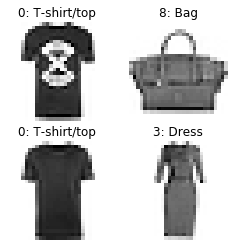

In [90]:
# get the first batch of images and labels
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(4,4))
for i in range(len(images)):
    l = labels[i].numpy()
    plt.subplot(2, 2, i+1)
    plt.title('%d: %s' % (l, labels_text[l]))
    plt.imshow(images[i].numpy()[0], cmap='Greys')
    plt.axis('off')

For the rest of today, we'll focus on creating a deep neural network that accurately classifies these images. This will highlight one application of deep learning, image processing, which has been highly successful. In upcoming classes, we'll see other examples of deep learning (GANs, LSTMs) which have different architectures and training rules. However, the basic principles remain the same!

# <a id="sec2">2. ANNs in Layers</a>

Last class, we looked at individual neurons organized in networks like this:

<img src="img/nn_fc.png" width="60%">

These two hidden layers are called "Fully Connected layers" because every neuron of these layers is connected to every neuron of the previous layer.

In PyTorch, Fully Connected layers are represented with the `torch.nn.Linear` function. The documentation is [here](https://pytorch.org/docs/stable/nn.html?highlight=torch%20nn%20linear#torch.nn.Linear) or we can ask Jupyter:

In [72]:
?torch.nn.Linear

Let's make a single fully connected layer:

In [73]:
from torch import nn
fc = nn.Linear(784, 10)

Let's use this layer as a network and construct a forward pass function. Our image data is 28 by 28, but we want it to match the layer dimensions. We'll transform the image from 28 by 28 to 1 by 784, and then pass the image through our fully connected layer.

In [74]:
def forward(x):
    x = x.view(-1, 28 * 28) # Transforms from (1, 28, 28) to (1, 784)
    x = fc(x) # Goes through fully connected layer
    return x # Output, 10 neurons

We'll take the maximum output as our label prediction. Let's see how this layer does - remember we haven't trained it, it's completely random.

In [75]:
for batch in range(3):
    images, labels = dataiter.next()
    for i in range(len(images)):
        outputs = forward(images[i])
        h = np.argmax(outputs.detach().numpy())
        y = labels[i]
        print('True: %d %s, Predicted: %d %s' % (y, labels_text[y], h, labels_text[h]))

True: 4 Coat, Predicted: 0 T-shirt/top
True: 9 Ankle boot, Predicted: 0 T-shirt/top
True: 1 Trouser, Predicted: 1 Trouser
True: 1 Trouser, Predicted: 5 Sandal
True: 6 Shirt, Predicted: 5 Sandal
True: 3 Dress, Predicted: 5 Sandal
True: 3 Dress, Predicted: 0 T-shirt/top
True: 5 Sandal, Predicted: 0 T-shirt/top
True: 8 Bag, Predicted: 0 T-shirt/top
True: 0 T-shirt/top, Predicted: 5 Sandal
True: 6 Shirt, Predicted: 0 T-shirt/top
True: 8 Bag, Predicted: 0 T-shirt/top


Let's double check that our fully connected layer is simply doing $$y = w^T x + b$$

In [76]:
a = (np.matmul(images[1].view(-1, 784), np.transpose(fc.weight.detach().numpy())) + fc.bias)[0].detach().numpy()
b = forward(images[1]).detach().numpy()
print('Numpy:\n', a)
print('PyTorch:\n', b)

Numpy:
 [ 0.26694435  0.15418431 -0.0801445  -0.37391877 -0.06608444  0.2804584
 -0.1528753  -0.07709439 -0.16068594 -0.05034055]
PyTorch:
 [[ 0.26694432  0.15418431 -0.08014453 -0.37391874 -0.06608443  0.2804584
  -0.15287529 -0.07709438 -0.16068594 -0.05034059]]


In [77]:
print(a == b, 'difference: ', np.sum((a-b)**2))

[[False  True False False False  True False False  True False]] difference:  5.3290705e-15


We have some slight errors due to floating point representation differences between PyTorch and numpy, but the calculation is the same!

<div class="alert alert-success">
Exercise 3:
    
1. The following code produces different predictions every time. Why? Change it so that it always predicts the same response.
2. Change the forward pass function to a network with the following fully connected layers: (784, 128), (128, 10). Test this network with random weights on some images.
    
</div>

In [78]:
def forward(x):
    x = x.view(-1, 28 * 28)
    x = nn.Linear(784,10)(x)
    return x

for i in range(len(images)):
    outputs = forward(images[i])
    h = np.argmax(outputs.detach().numpy())
    y = labels[i]
    print('True: %d %s, Predicted: %d %s' % (y, labels_text[y], h, labels_text[h]))

True: 8 Bag, Predicted: 9 Ankle boot
True: 0 T-shirt/top, Predicted: 0 T-shirt/top
True: 6 Shirt, Predicted: 8 Bag
True: 8 Bag, Predicted: 7 Sneaker


In [79]:
# %load solutions/ex3_1.py

In [80]:
# %load solutions/ex3_2.py

# <a id="sec3">3. Backpropagation and training</a>

Explain tensors and gradients

<img src="img/tensor.png" width="50%">



In [111]:
a = np.ones((2, 2))
b = torch.ones(2, 2)
np.all(b.numpy() == a)

True

In [119]:
x = torch.ones(2, 2, requires_grad=True)
print('x: ', x)
y = (x * x).mean()
print('y: ', y)
y.backward()
print('dy/dx: ', x.grad)

x:  tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
y:  tensor(1., grad_fn=<MeanBackward0>)
dy/dx:  tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])


In [100]:
x = torch.ones(2, 2, requires_grad=True)
print('x: ', x)
y = x + 2
print('y: ', y)
z = y * y * 3
print('z: ', z)
out = z.mean()
print('out: ', out)

x:  tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
y:  tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
z:  tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
out:  tensor(27., grad_fn=<MeanBackward0>)


In [101]:
out.backward()
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


If you want to go further in detail about this, check out the [autograd tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

In [81]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
net = Net()

One last thing before we train: we're calculting the gradients at every batch, not at every data point. This is an expensive gradient calculation, so let's reduce the number of times we do it by increasing the batch size. This has the benefit of reducing overfitting by computing the gradient over a large sample of images.

In [82]:
import torch.optim as optim

def train(net):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    total_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        total_loss += loss.item()
        if i > 10000:
            break
    return total_loss

In [83]:
%time total_loss = train(net)
print(total_loss)

/home/d9w/.venvs/37/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (10) must match the size of tensor b (128) at non-singleton dimension 1

1054.8911006450653


In [84]:
def get_test_predictions(net):
    testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
    all_labels = np.array([])
    predictions = np.array([])
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels = np.append(all_labels, labels.numpy())
            predictions = np.append(predictions, predicted.numpy())
    return all_labels, predictions

In [85]:
y_test, predictions = get_test_predictions(net)

In [86]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy: ")
print(accuracy_score(predictions, y_test))
print(classification_report(predictions, y_test, target_names=labels_text))

Accuracy: 
0.1008
              precision    recall  f1-score   support

 T-shirt/top       0.01      0.01      0.01       851
     Trouser       0.05      0.06      0.06       931
    Pullover       0.00      0.00      0.00         0
       Dress       0.00      0.00      0.00         8
        Coat       0.16      0.20      0.18       808
      Sandal       0.39      0.08      0.13      5051
       Shirt       0.00      0.00      0.00         6
     Sneaker       0.00      0.00      0.00         0
         Bag       0.39      0.19      0.25      2067
  Ankle boot       0.01      0.02      0.01       278

    accuracy                           0.10     10000
   macro avg       0.10      0.06      0.06     10000
weighted avg       0.30      0.10      0.14     10000



# Activation Functions

So far, our network is a chain of $$ Y = w^T x+b $$ However, last class we used the sigmoid activation function to do $$ Y = \sigma(w^T x+b) $$ Let's apply this to our current network and see how it changes training. Torch has two ways to do this: define a `torch.nn.Sigmoid` layer or apply the `torch.nn.functional.sigmoid` function (`torch.sigmoid` in future versions). We'll use the functional method.

In [87]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

net = Net()

In [88]:
train(net)

RuntimeError: The size of tensor a (10) must match the size of tensor b (128) at non-singleton dimension 1

In [ ]:
y_test, predictions = get_test_predictions(net)
print("Accuracy: ")
print(accuracy_score(predictions, y_test))
print(classification_report(predictions, y_test, target_names=labels_text))

## Softmax layers

For classification problems using one-hot encoding, our output 

$$\texttt{softmax}(x_i) = \frac{exp(x_i)}{\sum_{j}exp(x_j)}$$

In torch, the ReLU activation function is either a layer `torch.nn.Softmax` or a function in `torch.nn.functional.softmax`.

## ReLU: Solving vanishing gradients

Recall the shape of the sigmoid activation function?

In [ ]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

XX = np.arange(-5,5.,0.1)
plt.plot(XX,sigmoid(XX));

Let's plot the gradient of this function.

In [ ]:
def sigmoid_der(x):
    y = sigmoid(x)
    return y*(1.-y)

XX = np.arange(-5,5.,0.1)
plt.plot(XX,sigmoid(XX));
plt.plot(XX,sigmoid_der(XX));

Do you remember that during backpropagation, the $\delta_j$ were recursively obtained by:
$$\delta_j = \sigma'(y_j) \sum_{l\in L_j} \delta_l w_{jl}$$

This poses a major problem when the networks become deeper: at each layer, we multiply our gradients by $\sigma'(y_j)$ which is much smaller than 1. So the gradient we want to back-propagate shrinks to zero and all our weight updates become zero.

This is called the **vanishing gradient** problem.

To avoid this problem, we introduce a new type of activation function: the Rectified Linear Unit (ReLU).
$$\sigma(y) = \max\{0,y\}$$

The key property of this function is that its derivative is either zero or one.

In [ ]:
def relu(x):
    return np.maximum(0.,x)
def relu_der(x):
    return relu(x) > 0

plt.plot(XX,relu(XX));
plt.plot(XX,relu_der(XX));

**Caveat of using ReLU activation functions**

Although they allow us to train deep networks, ReLU functions have their downsides.
- Unbounded values: the output of a layer is not bounded anymore, causing possible divergence.
- Dying ReLU neurons: the backpropagation of gradients can push the input weigths towards values such that $\sigma(y)=0$ all the time. Then all future backpropagations will leave these weights unchanged: the neuron is dead.

Some advanced methods can compensate these weaknesses but are out of the scope of this introduction.

In torch, the ReLU activation function is either a layer `torch.nn.ReLU` or a function in `torch.nn.functional.relu`.

<div class="alert alert-success">
Exercise 5: Change your network to use ReLU activation for the hidden layer and a softmax as the output layer. Try changing layer sizes and activations to get a higher accuracy.
</div>

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

net = Net()
train(net)
y_test, predictions = get_test_predictions(net)
print("Accuracy: ")
print(accuracy_score(predictions, y_test))
print(classification_report(predictions, y_test, target_names=labels_text))

# Convolution and Pooling

# Overfitting

# Improving Optimization

# Neural Architectures

# Why go deep?
-> represent more complex functions with few neurons

example : 
(A and B) or (C and D)
it is more natural to have two hidden layers than to use lots of neurons on a single one.

Implement these two layers (no training) with Pytorch networks

# The problem with Deep Networks

Hard to train more than a few layers:
- lots of parameters require computing power
-> but highly paralellizable (especially on GPUs) and recent advances in hardware made it possible.
- vanishing gradients
-> let's force the gradient to be 1 => ReLU => but still the problem of vanishing of the "0" part (dying ReLUs) and the "sum" term in the update can cause divergence. That's the price to pay.

Ex: implement a 5 hidden layers NN in pytorch.
What data?

# Avoiding overfitting

Early stopping
Dropout
Regularization
Data augmentation

Ex: add dropout (or regularization) in the previous network.

# Can we have better convergence?

From SGD to ADAM.

# Detecting local features in spatially-distributed data: convolutions

# Going deeper: skip connections to preserve information flow

Going progressively deeper : AlexNet (5 conv layers), VGG (16 or 19 conv), Inception (22), ResNet (up to 1001).




# 1. <a id="sec1"></a>Neural network training with [Keras](https://keras.io/)

The following parts are strongly inspired by this [tutorial](https://github.com/Matt3164/Fashion_Keras).

There are many good Neural Networks libraries on the net. Among the most reknowned are Tensorflow, Theano, Pytorch or Caffe.

Keras is a minimalist, modular neural network library that can use either Theano or TensorFlow as a backend. The primary motivation behind Keras is that you should be able to experiment fast and go from idea to result as quickly as possible. Thus, Keras is perfect for training purposes and tutorials for beginners. Building networks in Keras feels easy and natural. It includes some of the latest state-of-the-art algorithms for optimizers (Adam, RMSProp), normalization (BatchNorm), and activation layers (PReLU, ELU, LeakyReLU). Although, Keras does not support multi-GPU environments for training a network in parallel.

<img src="img/keras-logo-small.jpg" width="200px">

# 2. <a id="sec2"></a>The Fashion-MNIST dataset

**New data!**

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits but is more complex.

Here's an example of how the data looks like (each class takes three-rows):

<img src="img/fashion-mnist-sprite.png">

You can find the official benchmark [here](https://github.com/zalandoresearch/fashion-mnist) but it does not contain deep learning performances. The performance on DL methods is expected to be between 90% and 95% on the test set according to the [community](https://medium.com/tensorist/classifying-fashion-articles-using-tensorflow-fashion-mnist-f22e8a04728a).

**Let's load the data.**

One nice thing is that Fashion MNIST has become part of the standard computer vision benchmarks and is included with most libraries, including Keras.

In [ ]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

Alternatively, one can download the data directly. Uncomment and run the cell below if the one above didn't work for some reason.

In [ ]:
#!mkdir -p data/fashion
#!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
#!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
#!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
#!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
#!mv *.gz data/fashion/

#from utils import mnist_reader
#X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
#X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [ ]:
print("Number of images for training: {}".format(X_train.shape[0]))
print("Image size: {}".format(X_train.shape[1:]))
print("Number of images for testing: {}".format(X_test.shape[0]))

So far, we have seen that neural networks take vectors as inputs, not images, so we need to "flatten" the 28x28 image into a 784-long single vector.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test  = X_test.reshape(X_test.shape[0], 784);
print(X_train.shape)
print(X_test.shape)

Display the first image (now that we have flattened all images, we need to reshape them to 28x28 to display them as images).

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_train[0,:].reshape(28, 28), cmap='Greys')
plt.axis("off");

In [ ]:
gridSize=16

plt.figure(figsize=(10,10))
for ind in range(gridSize*gridSize):
    plt.subplot(gridSize, gridSize, ind+1)
    plt.imshow(X_train[ind, :].reshape(28, 28), cmap="Greys")
    plt.axis("off")

Here is the label map and the class count in the training and testing sets.

In [ ]:
import numpy as np

Labels = ["T-shirt/top",
"Trouser",
"Pullover",
"Dress",
"Coat",
"Sandal",
"Shirt",
"Sneaker",
"Bag",
"Ankle boot"]

l, c = np.unique(y_train, return_counts=True)
lt, ct = np.unique(y_test, return_counts=True)

for idx, count, count_test in zip(l, c, ct):
    print("{0}: {1} / {2}".format(Labels[idx], count, count_test))

**One-hot encoding** is the representation of the target class as a vector of 0s and 1s.

In [ ]:
from keras.utils import to_categorical
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
print(y_train_ohe.shape)

# <a id="sec3"></a> 3. Our first neural network in Keras

**Our first network in Keras**

Let's keep it simple. There is no hidden layer:
- input dimension is $28\times28=784$
- output dimension is 10 (10 classes)

So our network is simply:
$$ Y = \sigma(w^T x+b) $$

The softmax function $\sigma$ normalizes all outputs so that they sum to 1. For a $K$-dimensional vector $z$:
$$\sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}$$

We shall use the cross entropy loss function:

<img src="img/cross-entropy.png" width="700px">

Let's declare a [feed-forward neural network](https://keras.io/getting-started/sequential-model-guide/).

In [ ]:
from keras.models import Sequential
model = Sequential()

Let's now add the output layer, indicating that its input is a 784 vector corresponding to our 28x28 grayscale image and that the layer is a [fully connected](https://keras.io/layers/core/#dense) one.

In [ ]:
from keras.layers import Dense
model.add(Dense(units=10, input_dim=X_train.shape[1]))

Let's indicate that the [activation function](https://keras.io/activations/) for this output layer is a softmax.

In [ ]:
from keras.layers import Activation
model.add(Activation('softmax'))

We want to optimize the cross-entropy loss but we would also like to monitor the accuracy and the "top 3 categorical accuracy" [metrics](https://keras.io/metrics/) (whether the true class is among the three most probable predicted classes) along the training, so we define it as a function.

In [ ]:
import keras.metrics as metrics
def top3_acc(ytrue, ypred):
    return metrics.top_k_categorical_accuracy(ytrue, ypred, k=3)

Finally, we want to use stochastic gradient descent as an [optimizer](https://keras.io/optimizers/) and optimize the cross-entropy [loss](https://keras.io/losses/). All this allows to fully define our optimization task and to [*compile* our model](https://keras.io/models/model/).

In [ ]:
import keras.losses as losses
import keras.optimizers as optimizers

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.SGD(lr=0.001),
              metrics=[metrics.categorical_accuracy, top3_acc])

**Let's train!**

In [ ]:
%%time
history = model.fit(X_train, y_train_ohe, validation_data=(X_test,y_test_ohe), epochs=400, batch_size=512)

It is common to plot different values obtained during training (by epoch). Keras provides the convenient [history](https://keras.io/visualization/#training-history-visualization) output to do so.

In [ ]:
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
for i, (name, values) in enumerate(sorted(history.history.items())):
    plt.subplot(1, len(history.history.items()), i+1)
    plt.plot(values)
    plt.title(name)

In case you stopped the optimization early and did not run it for the 400 epochs, here is what you should get after those 400 epochs:

<img src="img/training_history_1.png">

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model.predict(X_test).argmax(axis=1)

print("Accuracy: ")
print(accuracy_score(predictions, y_test))
print("\n\n")
print("Confusion matrix: ")
print(confusion_matrix(predictions, y_test))
print("\n\n")
print(classification_report(predictions, y_test, target_names=Labels))

Again, if you didn't run the optimization for 400 epochs, here is the result you should have found if you did:

```
Accuracy: 
0.5371



Confusion matrix: 
[[  0   0   0   0   0   0   0   0   0   0]
 [ 11 962  25  17   2   0   8   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [172  25  43 895  46   1  86   0   7   0]
 [ 18   7 379  35 847   1 145   0   4   0]
 [  0   0   1   1   1 982   0 997   7 998]
 [770   6 536  46  97   0 726   0  22   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 29   0  16   6   7  16  35   3 959   2]
 [  0   0   0   0   0   0   0   0   0   0]]



             precision    recall  f1-score   support

T-shirt/top       0.00      0.00      0.00         0
    Trouser       0.96      0.94      0.95      1026
   Pullover       0.00      0.00      0.00         0
      Dress       0.90      0.70      0.79      1275
       Coat       0.85      0.59      0.70      1436
     Sandal       0.98      0.33      0.49      2987
      Shirt       0.73      0.33      0.45      2203
    Sneaker       0.00      0.00      0.00         0
        Bag       0.96      0.89      0.93      1073
 Ankle boot       0.00      0.00      0.00         0

avg / total       0.89      0.54      0.64     10000```

Let's identify some misclassified items.

In [ ]:
import random

wrong_predictions = (predictions != y_test)
n_wp = wrong_predictions.sum()

N = 4
for i in range(N):
    idx = random.choice(range(n_wp))
    plt.figure()
    plt.imshow(X_test[wrong_predictions,::][idx,::].reshape(28, 28), cmap="Greys")
    plt.axis("off")
    plt.title("Predicted: {0} // Truth: {1}".format(
        Labels[predictions[wrong_predictions][idx]],
        Labels[y_test[wrong_predictions][idx]]
    ))

In [ ]:
X_train.shape[1]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras.metrics as metrics
import keras.losses as losses
import keras.optimizers as optimizers


def top3_acc(ytrue, ypred):
    return metrics.top_k_categorical_accuracy(ytrue, ypred, k=3)

model = Sequential()
model.add(Dense(units=200, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(units=150))
model.add(Activation('relu'))
model.add(Dense(units=50))
model.add(Activation('relu'))
#model.add(Dense(units=30))
#model.add(Activation('relu'))
model.add(Dense(units=10))
model.add(Activation('softmax'))

# Change decay for better results
# lr: 1e-3, decay: 0

N = X_train.shape[0]
batch_size = 32
n_batch = int(N/batch_size)

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.SGD(),
              metrics=[metrics.categorical_accuracy, top3_acc])

In [ ]:
%%time
history = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=50, batch_size=512)

In [ ]:
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
for i, (name, values) in enumerate(sorted(history.history.items())):
    plt.subplot(1, len(history.history.items()), i+1)
    plt.plot(values)
    plt.title(name)

In case you stopped the optimization early and did not run it for the 150 epochs, here is what you should get after those 150 epochs:

<img src="img/training_history_2_overfit.png">

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model.predict(X_test).argmax(axis=1)

print("Accuracy: ")
print(accuracy_score(predictions, y_test))
print("\n\n")
print("Confusion matrix: ")
print(confusion_matrix(predictions, y_test))
print("\n\n")
print(classification_report(predictions, y_test, target_names=Labels))

Again, if you didn't run the optimization for 150 epochs, here is the result you should have found if you did:

```
TODO
```

In [ ]:
import random

wrong_predictions = (predictions != y_test)
n_wp = wrong_predictions.sum()

N = 4
for i in range(N):
    idx = random.choice(range(n_wp))
    plt.figure()
    plt.imshow(X_test[wrong_predictions,::][idx,::].reshape(28, 28), cmap="Greys")
    plt.axis("off")
    plt.title("Predicted: {0} // Truth: {1}".format(
        Labels[predictions[wrong_predictions][idx]],
        Labels[y_test[wrong_predictions][idx]]
    ))

# 5. <a id="sec5"></a>Avoiding overfitting 

If you look closely, our network still suffers from overfitting. 

We are going to introduce four techniques to avoid that:

**Early-stopping**

TODO

**Dropout**

The idea of dropout is very simple. At each training epoch, some neurons are either "dropped out" of the network with probability $1 − p$ or kept with probability $p$, so that training occurs only on a pruned network. Incoming and outgoing edges to a dropped-out neuron are also removed. Only the pruned network is trained on the data in that epoch. The removed neurons are then reinserted into the network with their original weights.<br>
[**Dropout: A Simple Way to Prevent Neural Networks from Overfitting**. Srivastava et al., Journal of Machine Learning Research (2014).](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)

**Regularization**

Regularization is an idea borrowed to the general field of statistical learning. In the bias-variance compromise, a good way of allowing low bias while keeping low variance is to penalize the objective function with the norm of the parameters' vector. For example, we could include $\|\theta\|_1$ in the loss function.

**Data augmentation**

Data augmentation consists in artificially creating data by applying transformations on the input data. This way, we provide more examples to the classifier, that avoids overfitting by precisely overfitting the perturbed artificial data. It is particularly efficient when working with image data.

In this section we only experiment with dropout.

In [ ]:
from keras.layers import Dropout

dropout_rate=0.1

model = Sequential()
model.add(Dense(units=200, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(units=150))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(units=50))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(units=30))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(units=10))
model.add(Activation('softmax'))

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.SGD(lr=0.001, decay=0., nesterov=False),
              metrics=[metrics.categorical_accuracy, top3_acc])

In [ ]:
%%time
history = model.fit(X_train, y_train_ohe, validation_data=(X_test,y_test_ohe), epochs=150, batch_size=64)

In [ ]:
plt.figure(figsize=(20,10))

for i, (name, values) in enumerate(sorted(history.history.items())):
    plt.subplot(1, len(history.history.items()), i+1)
    plt.plot(values)
    plt.title(name)

In case you stopped the optimization early and did not run it for the 150 epochs, here is what you should get after those 150 epochs:

<img src="img/training_history_3.png">

In [ ]:
predictions = model.predict(X_test).argmax(axis=1)

print("Accuracy: ")
print(accuracy_score(predictions, y_test))
print("\n\n")
print("Confusion matrix: ")
print(confusion_matrix(predictions, y_test))
print("\n\n")
print(classification_report(predictions, y_test, target_names=Labels))

Again, if you didn't run the optimization for 150 epochs, here is the result you should have found if you did:

```
Accuracy: 
0.8829



Confusion matrix: 
[[825   2  14  17   0   0 118   0   5   0]
 [  1 963   0   5   0   0   1   0   0   0]
 [ 14   1 785   8  85   0 107   0   4   0]
 [ 28  25  12 894  24   1  26   0   3   0]
 [  3   4 123  44 851   0  70   0   3   0]
 [  1   0   0   2   0 952   0  13   3   5]
 [120   3  64  28  39   0 664   0  11   1]
 [  0   0   0   1   0  31   0 968   6  32]
 [  8   2   2   1   1   2  14   0 965   0]
 [  0   0   0   0   0  14   0  19   0 962]]



             precision    recall  f1-score   support

T-shirt/top       0.82      0.84      0.83       981
    Trouser       0.96      0.99      0.98       970
   Pullover       0.79      0.78      0.78      1004
      Dress       0.89      0.88      0.89      1013
       Coat       0.85      0.78      0.81      1098
     Sandal       0.95      0.98      0.96       976
      Shirt       0.66      0.71      0.69       930
    Sneaker       0.97      0.93      0.95      1038
        Bag       0.96      0.97      0.97       995
 Ankle boot       0.96      0.97      0.96       995

avg / total       0.88      0.88      0.88     10000
```

# 6. <a id="sec6"></a>Better optimizers

Stochastic Gradient Descent is our core method but improved optimizers are readily implemented in Keras. Most of them, like ADAM or RMSprop rely on the idea of including momentum in the gradient descent.

# 7. <a id="sec7"></a>Convolutional Neural Networks

The main factor which makes deep learning so useful for computer vision is the use of convolutions. Convolutional networks exploit the fact that the data is actually an image in the learning while decreasing the number of weights in the network. To do this, they define **convolution filters** that brush across the image. Such a filter defines a so-called **feature map** that shares the weights of the filter. The result of applying a feature map on an image is a new image of lower resolution, where each pixel is the result of the convolution of the filter with a set of pixels from the input image, as illustrated on the figure below.

<img src="img/convnet.gif" width="700px">

Another specificity of convolutional networks is **pooling**. Pooling is the operation of down-sampling the image by grouping together certain pixels. The most common pooling operation takes the maximum value over a certain window.

The following network is quite simple. It is a ConvNet, a family of networks built by stacking Conv/Pool blocks upon each other and adding a final set of dense layers as in the network below:
- Input layer: images of size $28\times 28$ with a single channel
- Convolutional layer of 16 feature maps with $5\times 5$ filters and ReLU activation functions
- Max pooling layer by blocks of size $2 \times 2$
- Convolutional layer of 16 feature maps with $5\times 5$ filters and ReLU activation functions
- Max pooling layer by blocks of size $2 \times 2$
- Fully connected layer with 200 ReLU neurons
- Fully connected output layer with 10 softwax neurons


In [ ]:
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten

model = Sequential()

model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(10, activation='softmax'))

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.SGD(lr=0.001, decay=0., nesterov=False),
              metrics=[metrics.categorical_accuracy, top3_acc])

Let's save a picture of our model.

In [ ]:
# requires pydot and graphviz (skip this step if you don't want to install them)
from keras.utils import plot_model
plot_model(model, to_file='model.png')

Let's train.

In [ ]:
%%time
history = model.fit(X_train.reshape(-1, 28, 28, 1), y_train_ohe, validation_data=(X_test.reshape(-1, 28, 28, 1),y_test_ohe), epochs=150, batch_size=64)

In [ ]:
plt.figure(figsize=(20,10))

for i, (name, values) in enumerate(sorted(history.history.items())):
    plt.subplot(1, len(history.history.items()), i+1)
    plt.plot(values)
    plt.title(name)

In case you stopped the optimization early and did not run it for the 150 epochs, here is what you should get after those 150 epochs:

<img src="img/training_history_4.png">

In [ ]:
predictions = model.predict(X_test.reshape(-1, 28, 28, 1)).argmax(axis=1)

print("Accuracy: ")
print(accuracy_score(predictions, y_test))
print("\n\n")
print("Confusion matrix: ")
print(confusion_matrix(predictions, y_test))
print("\n\n")
print(classification_report(predictions, y_test, target_names=Labels))

Again, if you didn't run the optimization for 150 epochs, here is the result you should have found if you did:

```
Accuracy: 
0.8825



Confusion matrix: 
[[784   3  13  12   2   0  90   0   1   0]
 [  1 970   1   7   1   0   5   0   0   0]
 [ 11   0 755   8  45   0  58   0   0   1]
 [ 26  17   7 897  28   0  32   0   5   1]
 [  2   4  95  33 823   0  50   0   3   0]
 [  5   0   1   0   0 955   0  13   1   5]
 [163   6 125  37  97   1 752   0  14   0]
 [  0   0   1   0   0  32   0 972   7  44]
 [  8   0   2   6   4   2  13   0 968   0]
 [  0   0   0   0   0  10   0  15   1 949]]



             precision    recall  f1-score   support

T-shirt/top       0.78      0.87      0.82       905
    Trouser       0.97      0.98      0.98       985
   Pullover       0.76      0.86      0.80       878
      Dress       0.90      0.89      0.89      1013
       Coat       0.82      0.81      0.82      1010
     Sandal       0.95      0.97      0.96       980
      Shirt       0.75      0.63      0.69      1195
    Sneaker       0.97      0.92      0.95      1056
        Bag       0.97      0.97      0.97      1003
 Ankle boot       0.95      0.97      0.96       975

avg / total       0.88      0.88      0.88     10000
```

# <a id="sec8"></a> 8. Going further

Deep Learning is a hot topic with new contributions almost every week. Interested readers can investigate further the topics above to get a deeper understanding or explore the following keywords for example:
- batch normalization
- recurrent networks and LSTM
- pretrain / fine-tune
- pre-trained networks
- generative adversarial networks